In [4]:
from pandas import DataFrame
from pandas import read_excel
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
# 한글 형태소 분석
# -> window
from eunjeon import Mecab
# -> mac, linux(colab)
#from konlpy.tag import Mecab
#from konlpy.tag import Okt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
df = read_excel('뉴스제목.xlsx', engine='openpyxl')
df

,document,label
0,송영길 순진한 김경수 드루킹에 이용박근혜 때 국정원 조작,정치
1,대법 징역년 확정에 김경수 그래도 진실 안 바뀌어,정치
2,저격수 추미애 주시간 발언으로 세상 이치 모른다는 것 드러내,정치
3,추미애 댓글 팀킬 결과에 김경수 광신자 배려 올가미됐다,정치
4,김경수 징역안타까워 대통령 사과해야,정치
...,...,...
31238,암호화폐 거래소 코빗 개인정보보호법 위반으로 과태료 만원 부과,IT/과학
31239,공정위 멜론 부당지원 제재 법적대응 예고,IT/과학
31240,취재수첩 년간 임금인상률 인데 연봉 왜 문제인가,IT/과학
31241,셧다운제 폐지 논란 불쏘시개 된 금 마인크래프트,IT/과학


## 문제2)

In [6]:
df['label'] = df['label'].replace({'정치' : 1, '경제' : 2, '사회': 3 ,'생활문화': 4, '세계': 5, 'IT/과학': 6})
df['label'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

In [7]:
df.groupby('label').count()

,document
label,
1,6141
2,8183
3,9985
4,2239
5,2925
6,1770


In [8]:
df

,document,label
0,송영길 순진한 김경수 드루킹에 이용박근혜 때 국정원 조작,1
1,대법 징역년 확정에 김경수 그래도 진실 안 바뀌어,1
2,저격수 추미애 주시간 발언으로 세상 이치 모른다는 것 드러내,1
3,추미애 댓글 팀킬 결과에 김경수 광신자 배려 올가미됐다,1
4,김경수 징역안타까워 대통령 사과해야,1
...,...,...
31238,암호화폐 거래소 코빗 개인정보보호법 위반으로 과태료 만원 부과,6
31239,공정위 멜론 부당지원 제재 법적대응 예고,6
31240,취재수첩 년간 임금인상률 인데 연봉 왜 문제인가,6
31241,셧다운제 폐지 논란 불쏘시개 된 금 마인크래프트,6


### 형태소 분석 객체 생성

In [9]:
mecab = Mecab()
morphs = mecab.morphs(df['document'][0])

#okt = Okt()
#morphs = okt.morphs(df['document'][10])
print(morphs)

['송영길', '순진', '한', '김경수', '드루', '킹', '에', '이용', '박근혜', '때', '국정원', '조작']


### 불용어 설정

In [10]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '걍', '때', '것', '위', '어']

### 형태소 분석 불용어 제거

In [11]:
word_set = []

for i, v in enumerate(df['document']):
    #morphs = okt.morphs(v)
    morphs = mecab.morphs(v)
    tmp_word = []
    for j in morphs:
        if j not in stopwords:
            tmp_word.append(j)
            
    word_set.append(tmp_word)
    
# 상위 3건만 출력해서 확인
word_set[:3]

[['송영길', '순진', '김경수', '드루', '킹', '이용', '박근혜', '국정원', '조작'],
 ['대법', '징', '역년', '확정', '김경수', '그래도', '진실', '안', '바뀌'],
 ['저격수', '추미애', '주', '시간', '발언', '세상', '이치', '모른다는', '드러내']]

### 토큰화

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(word_set)
len(tokenizer.word_index)

22258

### 희귀단어 제거

In [13]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 22258
등장 빈도가 2번 이하인 희귀 단어의 수: 11627
단어 집합에서 희귀 단어의 비율: 52.23739778955881
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.514691393265256


### 단어집합 크기 설정

In [14]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 10633


In [15]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(word_set)
token_set = tokenizer.texts_to_sequences(word_set)
len(token_set)

31243

## 문제3)

### 빈샘플 제거

In [16]:
drop_train = []

for i, v in enumerate(token_set):
    if len(v) < 1:
        drop_train.append(i)
        
len(drop_train)

3

In [17]:
fill_token_set = np.delete(token_set, drop_train, axis=0)
len(fill_token_set)

c:\users\junhong\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


31240

In [15]:
lables = np.delete(np.array(df['label']), drop_train)
len(lables)

31240

제목의 최대 길이 : 34
제목의 평균 길이 : 10.42903329065301


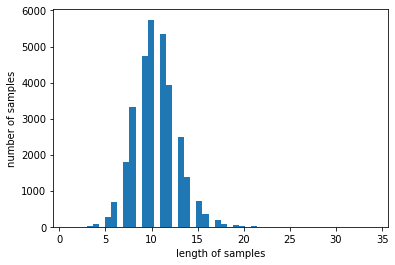

In [16]:
print('제목의 최대 길이 :',max(len(l) for l in fill_token_set))
print('제목의 평균 길이 :',sum(map(len, fill_token_set))/len(fill_token_set))
plt.hist([len(s) for s in fill_token_set], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### 패딩처리

In [17]:
pad_token_set = pad_sequences(fill_token_set, maxlen=15)

## 문제4)

In [18]:
np.random.seed(777)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(pad_token_set, lables, test_size = 0.3, random_state = 777)
print("훈련용 데이터셋 크기: %d, 검증용 데이터셋 크기: %d" % (len(x_train),  len(x_test)))

훈련용 데이터셋 크기: 21868, 검증용 데이터셋 크기: 9372


### 종속변수 1_hot_encoding

In [20]:
y_train = y_train.astype('int')
y_train_1hot = to_categorical(y_train)
y_train_1hot 

y_test = y_test.astype('int')
y_test_1hot = to_categorical(y_test)
y_test_1hot 

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

### GRU모델 생성

In [21]:
model = Sequential() 
model.add(Embedding(vocab_size, 32)) 
model.add(GRU(128)) 
model.add(Dense(7, activation='softmax')) 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          340256    
_________________________________________________________________
gru (GRU)                    (None, 128)               62208     
_________________________________________________________________
dense (Dense)                (None, 7)                 903       
Total params: 403,367
Trainable params: 403,367
Non-trainable params: 0
_________________________________________________________________


In [22]:
result = model.fit(x_train, y_train_1hot, epochs=50, validation_data=(x_test, y_test_1hot), callbacks = [
    #ModelCheckpoint(filepath = 'check_point.h5', monitor = 'val_loss', verbose=1, save_best_only = True),
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

Epoch 1/50
684/684 [==============================] - 8s 9ms/step - loss: 1.0780 - accuracy: 0.6056 - val_loss: 0.7912 - val_accuracy: 0.7373
Epoch 2/50
684/684 [==============================] - 6s 8ms/step - loss: 0.5925 - accuracy: 0.8026 - val_loss: 0.7313 - val_accuracy: 0.7491
Epoch 3/50
684/684 [==============================] - 6s 8ms/step - loss: 0.4230 - accuracy: 0.8571 - val_loss: 0.7905 - val_accuracy: 0.7456
Epoch 4/50
684/684 [==============================] - 5s 8ms/step - loss: 0.3259 - accuracy: 0.8884 - val_loss: 0.8729 - val_accuracy: 0.7329
Epoch 5/50
684/684 [==============================] - 5s 8ms/step - loss: 0.2542 - accuracy: 0.9152 - val_loss: 0.9455 - val_accuracy: 0.7311

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
684/684 [==============================] - 6s 8ms/step - loss: 0.1627 - accuracy: 0.9471 - val_loss: 1.0616 - val_accuracy: 0.7309
Epoch 7/50
684/684 [==============================] - 6s 8ms/step -

,loss,accuracy,val_loss,val_accuracy,lr
epochs,,,,,
1,1.078007,0.605588,0.791188,0.737303,0.0010
2,0.592493,0.802634,0.731318,0.749146,0.0010
3,0.422979,0.857143,0.790523,0.745625,0.0010
4,0.325939,0.888376,0.872938,0.732928,0.0010
5,0.254177,0.915219,0.945471,0.731114,0.0010
6,0.162678,0.947092,1.061553,0.730901,0.0005
7,0.126874,0.959027,1.217324,0.731114,0.0005


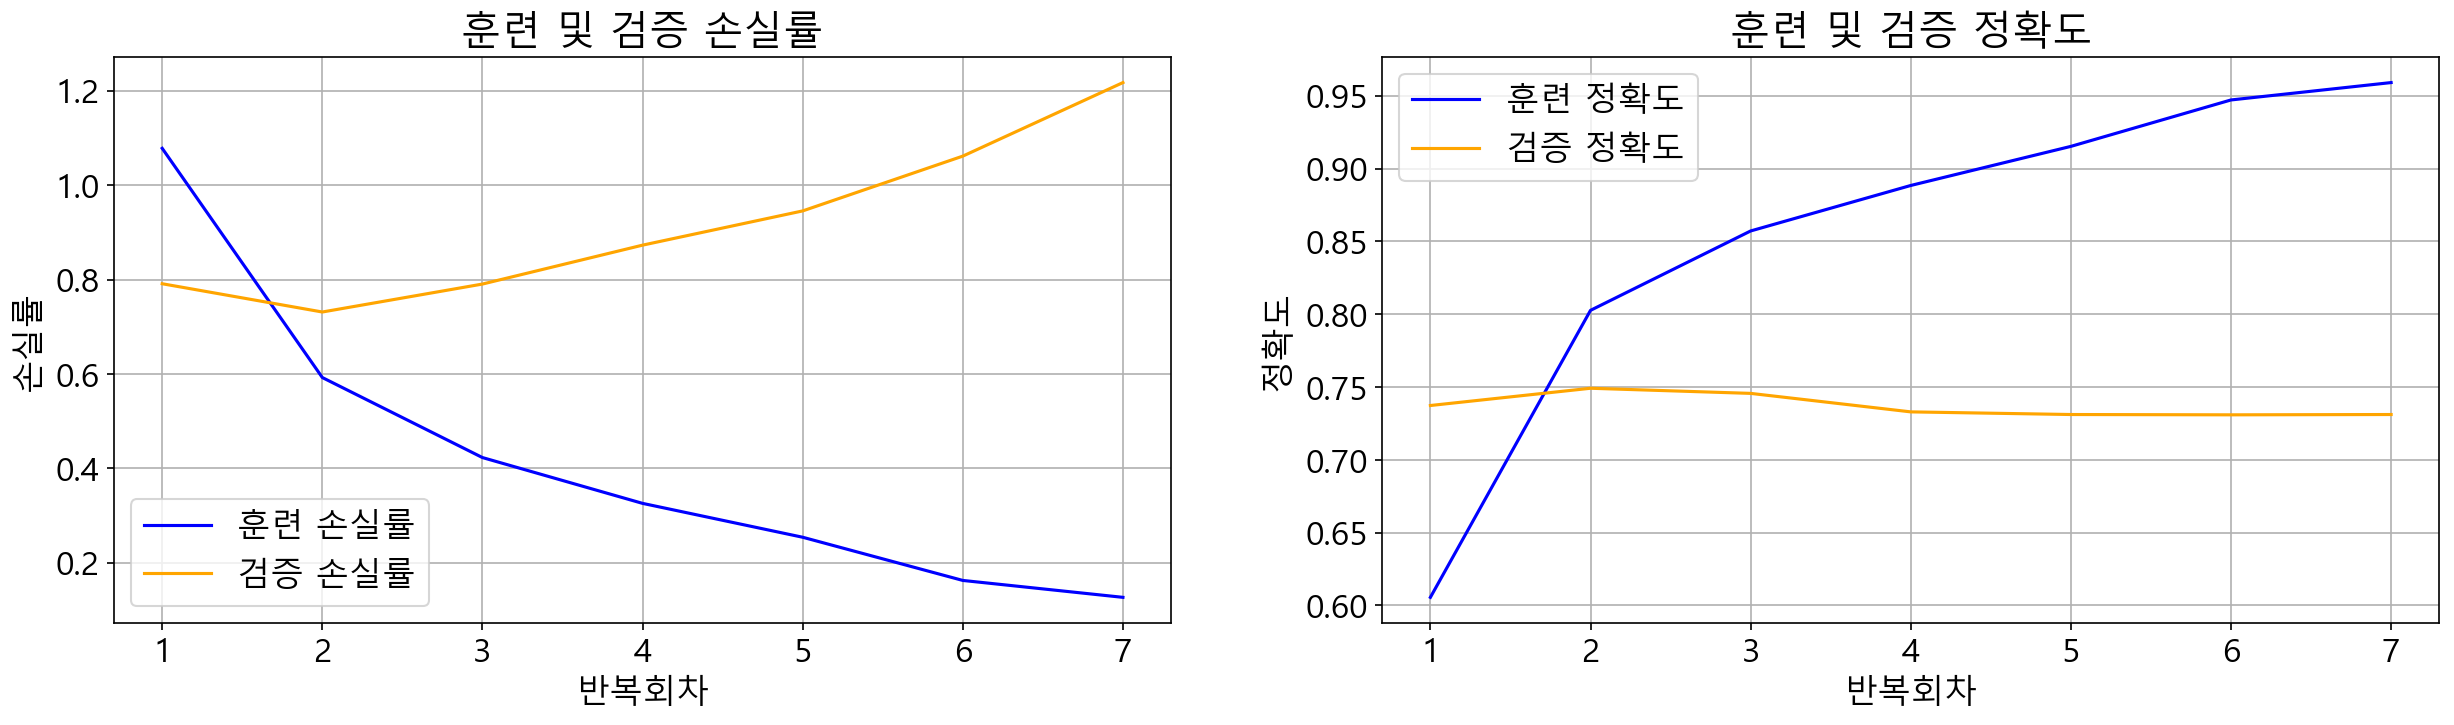

In [23]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sns.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sns.lineplot(x=result_df.index, y='accuracy', data=result_df, color = 'blue', label = '훈련 정확도', ax=ax2)
sns.lineplot(x=result_df.index, y='val_accuracy', data=result_df, color = 'orange', label = '검증 정확도', ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

#plt.savefig('result.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()

In [24]:
evaluate = model.evaluate(x_test, y_test_1hot)
print("최종 손실률: %f, 최종 정확도: %f" % (evaluate[0], evaluate[1]))

293/293 [==============================] - 1s 3ms/step - loss: 1.2173 - accuracy: 0.7311
최종 손실률: 1.217324, 최종 정확도: 0.731114


## 문제5)

In [25]:
result = model.predict(x_test)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

9372개의 검증 데이터가 7개의 경우의 수를 갖는다.


array([1.8414087e-07, 2.5213280e-05, 2.3486896e-04, 6.6478848e-02,
       9.3202585e-01, 2.8560828e-05, 1.2064721e-03], dtype=float32)

In [26]:
np.argmax(result,axis=1)

array([4, 1, 5, ..., 4, 6, 2], dtype=int64)

In [27]:
kdf = DataFrame({
    '결과값': np.argmax(y_test_1hot,axis=1),
    '예측치' : np.argmax(result,axis=1)
})

kdf['예측치'] = kdf['예측치'].astype('int')
kdf

,결과값,예측치
0,4,4
1,1,1
2,5,5
3,1,2
4,3,3
...,...,...
9367,2,3
9368,3,3
9369,4,4
9370,2,6


In [28]:
cm = confusion_matrix(kdf['결과값'], kdf['예측치'])
cmdf1 = DataFrame(cm, columns=['예측값(정치)', '예측값(경제)','예측값(사회)','예측값(생활/문화)','예측값(세계)','예측값(IT/과학)'], index=['실제값(정치)', '실제값(경제)','실제값(사회)', '실제값(생활/문화)','실제값(세계)', '실제값(IT/과학)'])
cmdf1

,예측값(정치),예측값(경제),예측값(사회),예측값(생활/문화),예측값(세계),예측값(IT/과학)
실제값(정치),1536,72,172,9,44,12
실제값(경제),71,1829,232,50,84,159
실제값(사회),219,198,2377,120,82,37
실제값(생활/문화),34,109,164,288,35,38
실제값(세계),30,95,105,19,583,32
실제값(IT/과학),14,180,40,35,29,239


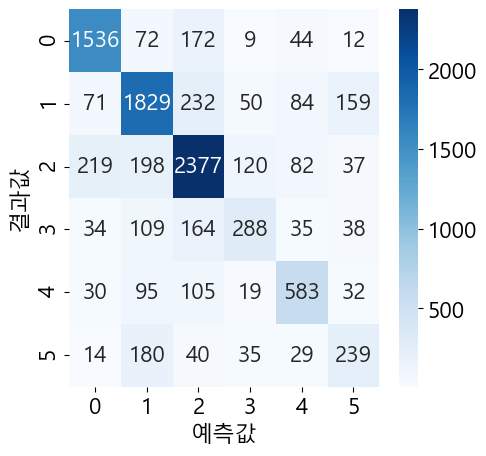

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
# 오차 행렬을 히트맵 그래프로 표현
# -> annot : 그래프의 각 칸에 수치값 출력
# -> fmt : 수치값 출력 format (여기서는 10진수)
# -> cmap : 색상맵 (https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html)
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues', ax=ax)
ax.set_xlabel('예측값')
ax.set_ylabel('결과값')
plt.show()
plt.close()